In [1]:
%env CUDA_VISIBLE_DEVICES=0
%env XLA_PYTHON_CLIENT_PREALLOCATE=false
%env JAX_ENABLE_X64=True

from datasets import PointDataset
from models import MLPCNF

env: CUDA_VISIBLE_DEVICES=0
env: XLA_PYTHON_CLIENT_PREALLOCATE=false
env: JAX_ENABLE_X64=True


In [2]:
import jax.random as jr

dataset = PointDataset(dim=3)
xshape, yshape = dataset.xy_shape()

model = MLPCNF(x_dim=xshape[-1], y_dim=yshape[-1], hidden=64, depth=4, rng=jr.key(0))
model, losses = model.fit(dataset, batch_size=1024, epochs=10, learning_rate=3e-4)

100%|██████████| 10/10 [00:08<00:00,  1.18it/s, loss=0.04970087284844164]


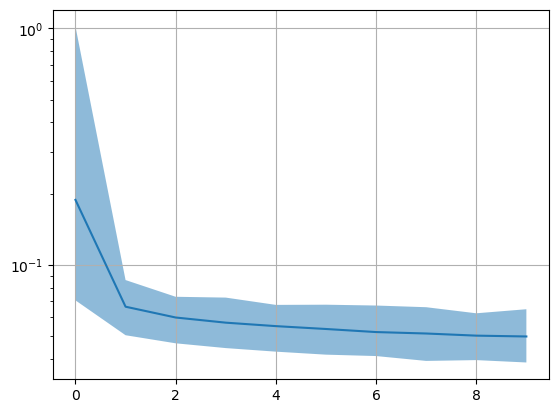

In [3]:
import matplotlib.pyplot as plt
plt.semilogy(losses.mean(axis=-1))
plt.fill_between(range(len(losses)), losses.min(axis=-1), losses.max(axis=-1), alpha=0.5)
plt.grid()
plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]

(32768, 3)


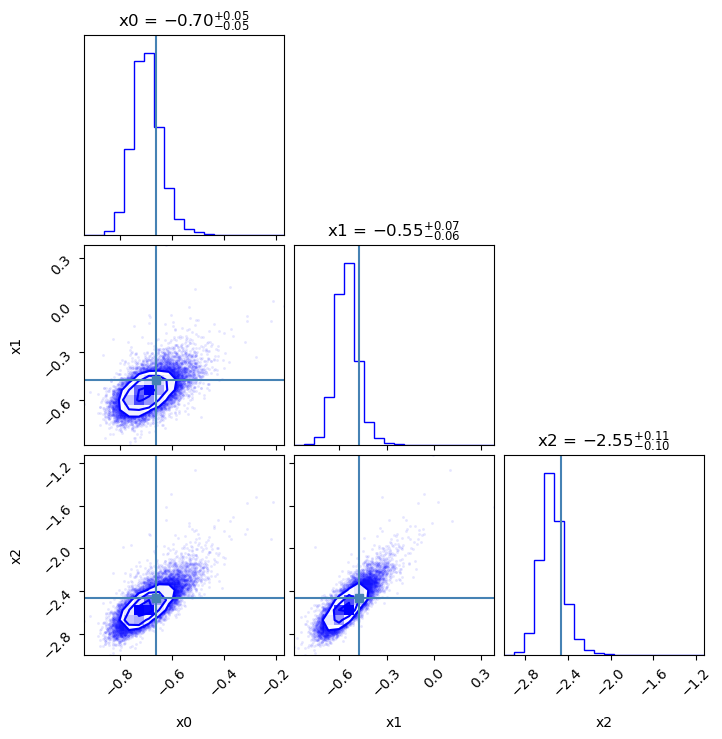

In [4]:
#from utils import corner_plot
#corner_plot(dataset, model, examples=10, samples=32*1024, verbose=True)

from tqdm.auto import tqdm
import corner
from mcmc import emcee_sample
import numpy as np

import jax
import jax.numpy as jnp
import jax.random as jr


def corner_plot(
    dataset,
    model,
    verbose=False,
    samples=32 * 1024,
    examples=1,
    ode_steps=8,
    plot_prior=False,
    seed=0,
):
    @jax.jit
    def sample(rng):
        rng_x0, rng_x1, rng_y = jr.split(rng, 3)
        x0 = jax.vmap(dataset.sample_params)(jr.split(rng_x0, samples))
        x1 = dataset.sample_params(rng_x1)
        y = dataset.sample_observation(rng_y, x1)

        x0_triv = jnp.concat(jax.vmap(dataset.as_trivial)(x0), axis=-1)
        return x0, x1, y, x0_triv
    
    
    def batch_push(x0_triv,y):
        return model.push(x0_triv, y, n_steps=ode_steps)[0]
    batch_push=jax.jit(jax.vmap(batch_push,in_axes=(0,None)))

    for rng in tqdm(jr.split(jr.key(seed), examples)):
        x0, x1, y, x0_triv = sample(rng)
        truths = np.array(jnp.concat(x1, axis=-1))

        # sample using CNF
    
        x_cnf =np.array(batch_push(x0_triv,y))

        # # sample using MCMC
        # x_mcmc = emcee_sample(
        #     log_prob=lambda x: dataset.log_posterior(x, y),
        #     x0=x1,
        #     walkers=64,
        #     steps=len(x_cnf) // 64,
        #     burn=300,
        #     verbose=verbose,
        # )

        # plot corner
        corner_kwargs: dict = dict(
            labels=dataset.param_names, show_titles=True, truths=truths
        )
        fig = None
        if plot_prior:
            fig = corner.corner(x0, color="black", **corner_kwargs)
        print(x_cnf.shape)
        fig = corner.corner(x_cnf, color="blue", fig=fig, **corner_kwargs)
        # fig = corner.corner(x_mcmc, color="green", fig=fig, **corner_kwargs)

corner_plot(dataset,model)